In [101]:
import time
from copy import deepcopy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pettingzoo
from pettingzoo import AECEnv
from pettingzoo.utils.agent_selector import agent_selector

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [102]:
def encode_state():
    state = tf.keras.Input(shape=(1, 6))
    output = tf.keras.layers.Dense(32, activation='relu', name='Dense1')(state)
    model = tf.keras.Model(inputs=[state], outputs=[output], name='StateEncoder')
    return model

Model: "GraphAttentionNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
State (InputLayer)              [(None, 1, 6)]       0                                            
__________________________________________________________________________________________________
StateEncoder (Functional)       (None, 1, 32)        224         State[0][0]                      
__________________________________________________________________________________________________
tf.math.reduce_mean_12117 (TFOp (None, 1, 32)        0           StateEncoder[0][0]               
__________________________________________________________________________________________________
Agent (InputLayer)              [(None, 1, 1)]       0                                            
______________________________________________________________________________

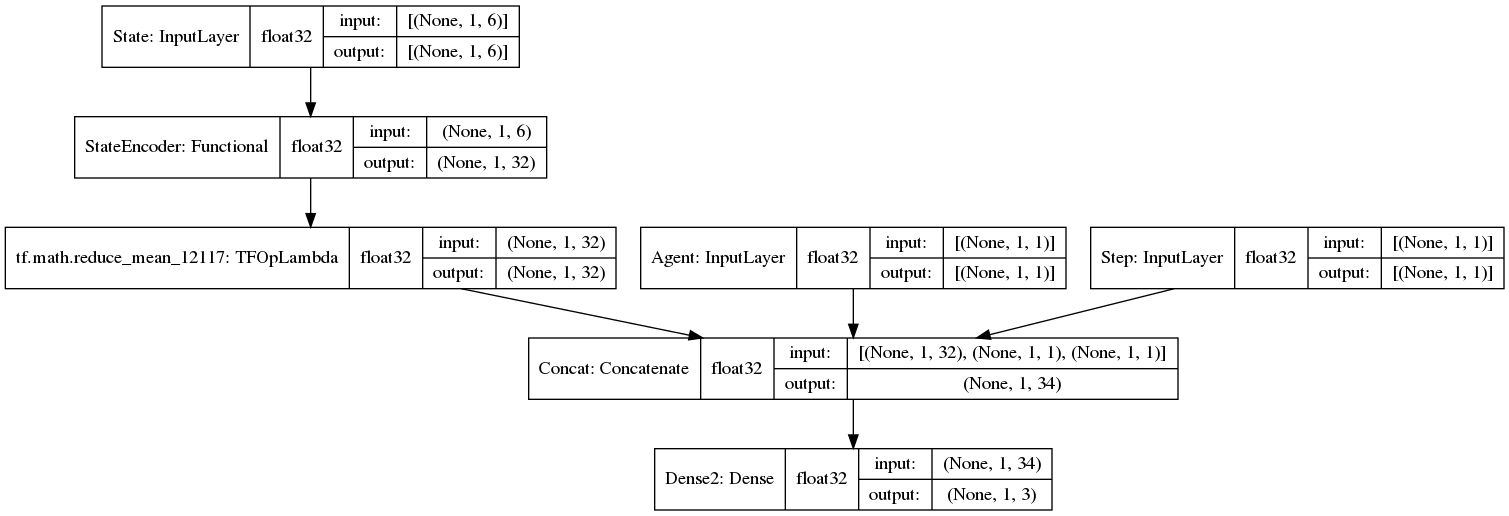

In [103]:
def graph_attention_network():
    state = tf.keras.Input(shape=(1, 6), name='State')
    agent = tf.keras.Input(shape=(1, 1), name='Agent')
    step = tf.keras.Input(shape=(1, 1), name='Step')
    
    state_encoder = encode_state()
    initial_node_embeddings = state_encoder(state)
    initial_graph_embeddings = tf.math.reduce_mean(initial_node_embeddings, axis=1, keepdims=True, name='GraphEmb')
    
    emb_context = tf.keras.layers.Concatenate(axis=2, name='Concat')([initial_graph_embeddings, agent, step])
    
    policy = tf.keras.layers.Dense(3, activation='linear', name='Dense2')(emb_context)    
    
    model = tf.keras.Model(inputs=[state, agent, step], outputs=[policy], name='GraphAttentionNetwork')
    return model

# tf.random.set_seed(123)

observation = np.full(shape=(1, 1, 6), fill_value=-1.)
agent = np.full(shape=(1, 1, 1), fill_value=1.)
step = np.full(shape=(1, 1, 1), fill_value=1.)

model = graph_attention_network()
model.compile(optimizer=tf.keras.optimizers.Adam())
action = model([observation, agent, step])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=False)

In [104]:
class VectorAction(AECEnv):
    def __init__(self, n_agents=2, batch_size=512):
        super().__init__()
        self.batch_size = batch_size
        self.agents = ['agent_0', 'agent_1']
        self.possible_agents = self.agents[:]
        
    def observe(self, agent):
        return self.observation
            
    def reset(self):
        self.agents = self.possible_agents[:]
        self.rewards = {i: 0 for i in self.agents}
        self._cumulative_rewards = {name: 0 for name in self.agents}
        self.dones = {i: False for i in self.agents}
        self.infos = {i: {} for i in self.agents}
        self.actual_rewards = np.zeros(shape=(self.batch_size, 1))

        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.reset()

        self.observation = np.full(shape=(self.batch_size, 1, 6), fill_value=-1.)
        return self.observation
        
    def step(self, action, agent):
        if self.dones[self.agent_selection]:
            return self._was_done_step(action)
        
        if agent == 'agent_0':
            self.observation[:,0,:3] = tf.squeeze(action, 1)
        elif agent == 'agent_1':
            self.observation[:,0,3:] = tf.squeeze(action, 1)
            self.dones = {i: True for i in self.agents}
            
            for minibatch in range(self.batch_size):
                # If starts with 0, all should be 0
                if self.observation[minibatch,0,0] == 0:
                    if np.sum(self.observation[minibatch,0,::2]) == 0 and np.sum(self.observation[minibatch,0,1::2]) == 3:
                        self.actual_rewards[minibatch] = 1.
                    else:
                        self.actual_rewards[minibatch] = -1.
                elif self.observation[minibatch,0,0] == 1:
                    if np.sum(self.observation[minibatch,0,::2]) == 3 and np.sum(self.observation[minibatch,0,1::2]) == 0:
                        self.actual_rewards[minibatch] = 1.
                    else:
                        self.actual_rewards[minibatch] = -1.
            
            self.rewards = {i: self.actual_rewards for i in self.agents}
            
        next_agent = self._agent_selector.next()
        self.agent_selection = next_agent
        self._accumulate_rewards()

In [105]:
class VPGAgent:
    def __init__(self):
        self.model = graph_attention_network()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=2.0))
        
    def reset(self):
        self.history = {}
        self.history['states'] = []
        self.history['actions'] = []
        self.history['agent'] = []
        self.history['step'] = []
        
    def store_transition(self, transition):
        self.history['states'].append(deepcopy(transition['states']))
        self.history['actions'].append(deepcopy(transition['actions']))
        self.history['agent'].append(deepcopy(transition['agent']))
        self.history['step'].append(deepcopy(transition['step']))
        
    def learn(self, reward, tensorboard_writer, episode):
        
        states = tf.concat(self.history['states'], axis=0)
        actions = tf.concat(self.history['actions'], axis=0)
        agents = tf.concat(self.history['agent'], axis=0)
        steps = tf.concat(self.history['step'], axis=0)
        
        reward = tf.cast(tf.tile(reward, multiples=[2, 1]), tf.float32)
                
        with tf.GradientTape() as tape:
            logits = self.model([states, agents, steps])
            action_dist = tfp.distributions.Binomial(total_count=1, logits=logits)
            log_probs = action_dist.log_prob(actions)
            
            loss = -1 * log_probs * reward
                        
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        
        if tensorboard_writer:
            with tensorboard_writer.as_default():
                tf.summary.scalar('Average Loss', tf.math.reduce_mean(loss).numpy().squeeze(), step=episode)
                tf.summary.scalar('Average LogProb', tf.math.reduce_mean(log_probs).numpy().squeeze(), step=episode)
#                 tf.summary.scalar('Entropy', tf.math.reduce_mean(action_dist.entropy()).numpy().squeeze(), step=episode)

                
                for weight, grad in zip(self.model.trainable_weights, grads):
                    tf.summary.histogram(weight.name, weight, step=episode)
                    tf.summary.histogram(weight.name + '_grads', grad, step=episode)


In [106]:
start = time.time()

batch_size = 512

env = VectorAction(batch_size=batch_size)
actor = VPGAgent()

tf.random.set_seed(123)
N_EPISODES = 20000

rewards = []

folder_name = time.strftime('%Y%m%d_%H%M%S')
folder_name += f'-multilabel_batch_size={batch_size}'

TENSORBOARD_WRITER = tf.summary.create_file_writer(folder_name)

for episode in range(N_EPISODES):
    env.reset()
    actor.reset()
    for agent in env.agent_iter():        
        observation, reward, done, info = env.last()

        agent_idx = 0 if agent == 'agent_0' else 1
        agent_np = np.full(shape=(batch_size, 1, 1), fill_value=agent_idx)

        if not done:
            step = np.full(shape=(batch_size, 1, 1), fill_value=0)
            model = graph_attention_network()
            logits = actor.model([observation, agent_np, step])

            action_dist = tfp.distributions.Binomial(total_count=1, logits=logits)
            action = action_dist.sample()
            transition = {'states': observation,
                          'actions': action,
                          'agent': agent_np,
                          'step': step}

            actor.store_transition(transition)
            
        else:
            action = None
            
        env.step(action, agent)
        
        if done and agent == 'agent_1':
            with TENSORBOARD_WRITER.as_default():
                tf.summary.scalar('Average Reward', np.mean(reward), step=episode)           
            actor.learn(reward, TENSORBOARD_WRITER, episode)
            rewards.append(reward)

print(f'This took {time.time() - start} seconds to run')

KeyboardInterrupt: 

In [89]:
# observation = np.full(shape=(1, 1, 6), fill_value=-1.)
# agent = np.full(shape=(1, 1, 1), fill_value=1.)
# step = np.full(shape=(1, 1, 1), fill_value=1.)

observation = np.array([[[-1., -1., -1., -1., -1., -1.]]])
agent = np.array([[[0]]])
step = np.array([[[0.]]])

logits = actor.model([observation, agent, step])
probs = tf.math.softmax(logits)
print(probs)
action_dist = tfp.distributions.Binomial(total_count=1, probs=probs)
action = action_dist.sample()
print(action)

tf.Tensor([[[0.8935766  0.02197086 0.08445249]]], shape=(1, 1, 3), dtype=float32)
tf.Tensor([[[1. 0. 0.]]], shape=(1, 1, 3), dtype=float32)


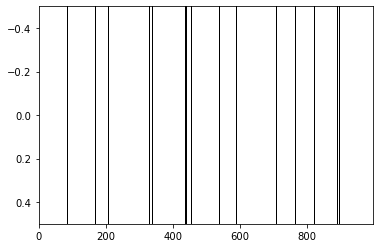

In [170]:
import matplotlib.pyplot as plt
barprops = dict(aspect='auto', cmap='binary', interpolation='nearest')

plt.imshow(np.where(np.array(rewards) > 0, 1, 0).reshape(1, -1), **barprops)
plt.show()

In [26]:
def decode_state():
    embedded_state = tf.keras.Input(shape=(32,), name='EmbeddedState')
    embedded_context = tf.keras.Input(shape=(32,), name='EmbeddedContext')

    context_encoder = encode_context()
    embedded_state = context_encoder([embedded_state, encoder_output, agent, step])

    decoder = tf.keras.Model(inputs=[embedded_state, agent, step], outputs=[embedded_state])
    encoder.compile(run_eagerly=True)
    
    return decoder

# decoder.summary()
# tf.keras.utils.plot_model(encoder, show_shapes=True, show_dtype=True, expand_nested=True)

In [152]:

#     if agent == 'agent_0':
#         return np.array([[0], [1], [0]])
#     elif agent == 'agent_1':
#         return np.array([[1], [0], [1]])
#     else:
#         raise ValueError(f'Unknown agent name {agent}')


In [42]:
a = np.random.rand(1, 32)
b = np.random.rand(1, 1)
a.shape, b.shape
a, b

(array([[0.95422575, 0.56626489, 0.40021879, 0.97758747, 0.8555363 ,
         0.82916915, 0.11852359, 0.334082  , 0.65206015, 0.37601626,
         0.56313969, 0.25984254, 0.53109729, 0.98856876, 0.9120596 ,
         0.56106924, 0.26356947, 0.77364669, 0.43475422, 0.8733976 ,
         0.92031003, 0.58527672, 0.28506535, 0.85006006, 0.13111608,
         0.80426483, 0.71586189, 0.45594922, 0.22074613, 0.62957735,
         0.56567521, 0.18387716]]),
 array([[0.87261738]]))

In [43]:
np.concatenate((a, b), axis=-1)

array([[0.95422575, 0.56626489, 0.40021879, 0.97758747, 0.8555363 ,
        0.82916915, 0.11852359, 0.334082  , 0.65206015, 0.37601626,
        0.56313969, 0.25984254, 0.53109729, 0.98856876, 0.9120596 ,
        0.56106924, 0.26356947, 0.77364669, 0.43475422, 0.8733976 ,
        0.92031003, 0.58527672, 0.28506535, 0.85006006, 0.13111608,
        0.80426483, 0.71586189, 0.45594922, 0.22074613, 0.62957735,
        0.56567521, 0.18387716, 0.87261738]])

In [68]:
def policy(observation, agent):
    if agent == 'agent_0':
        return np.array([[1], [1], [0]])
    elif agent == 'agent_1':
        return np.array([[1], [0], [1]])
    else:
        raise ValueError(f'Unknown agent name {agent}')